In this notebook, we will use regression algorithms to predict the number of rented bikes for a given day

### Load data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

seed=99
random.seed(seed)
np.random.seed(seed)

In [47]:
rental = pd.read_csv('data/rental.csv')

#### Preprocessing

Usually, standardization and normalization may be used on the independent variables as some machine learning algorithm is sensitive to the scale and distribution of the data such as SVM and linear regression. Scaling issues may result in features with larger values having more importance than others and ignore the features with lower values, impacting the model performance.

From our EDA phase, we do not see any significant scaling issues, even though some of the features with numerical label encoding do have higher values.

# Predictive modeling

Standardization function is copied from PS4:

In [3]:
import numpy as np

def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

In [48]:
from sklearn.model_selection import train_test_split

X = rental.loc[:, rental.columns != 'cnt']
y = rental['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X.head()

,mnth,hr,weekday,temp,atemp,hum,windspeed,season_1,season_2,season_3,season_4,holiday_0,holiday_1,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,1,0,6,0.24,0.2879,0.81,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1,1,6,0.22,0.2727,0.80,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1,2,6,0.22,0.2727,0.80,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1,3,6,0.24,0.2879,0.75,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1,4,6,0.24,0.2879,0.75,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


## Method 1: Multiple Linear Regression

In [49]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
score = lin_reg.score(X_train, y_train)
print(f'Predictive score on training data {score:.4f}')

score = lin_reg.score(X_test, y_test)
print(f'Predictive score on test data {score:.4f}')

Predictive score on training data 0.3477
Predictive score on test data 0.3646


The linear regression model provides us with a baseline which we can compare our other predictive algorithms on. This model got a score of 0.69 on the training data and 0.67 on the test set.

## Method 2. Gradient Boosting

#### Default model

In [50]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

gbm = GradientBoostingRegressor(random_state=seed)

# Fit the model and make prediction
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)

# Evaluate the model
cross_score = np.mean(cross_val_score(gbm, X_train, y_train, cv=10))
train_score = gbm.score(X_train, y_train)
test_score = gbm.score(X_test, y_test)


print('Training set {:.4f}'.format(train_score))
print('Cross-validated set: {:.4f}'.format(cross_score))
print('Test set: {:.4f}'.format(test_score))

Training set 0.7909
Cross-validated set: 0.7859
Test set: 0.7862


#### Finetuned model
Use a grid search algorithm to find the best hyperparameters for the gradient boosting algorithm.

In [9]:
%%time
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [2, 5, 6, 7, 9, 11],
    'n_estimators': [10, 50, 100],
    'min_samples_leaf': [1, 3, 5, 7, 9]
}

gbm = GradientBoostingRegressor(random_state=seed)

cv_search = GridSearchCV(gbm, param_grid, cv=5, verbose=True, n_jobs=-1).fit(X_train, y_train)
print("best parameters:", cv_search.best_params_)
# best parameters: {'learning_rate': 0.1, 'max_depth': 11, 'min_samples_leaf': 7, 'n_estimators': 100}

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
best parameters: {'learning_rate': 0.1, 'max_depth': 11, 'min_samples_leaf': 9, 'n_estimators': 100}
CPU times: user 7.53 s, sys: 1.1 s, total: 8.64 s
Wall time: 5min 8s


In [10]:
print('Training set {:.4f}'.format(cv_search.best_estimator_.fit(X_train, y_train).score(X_train, y_train)))
print('Cross-validated set: {:.4f}'.format(cv_search.best_score_))
print('Test set: {:.4f}'.format(cv_search.best_estimator_.score(X_test, y_test)))

Training set 0.9840
Cross-validated set: 0.9368
Test set: 0.9422


The first model was trained using the default parameters of the gradient boosting algorithm and got a significant higher score than the multiple regression model with an increase from 0.68 to 0.79.

Due to the performance of the gradient boosting algorithm, we decided to finetune the hyperparameters to see if we could get a better performance. After using grid search to test out combinations of different parameters we got a satisfying result of 0.9840 on the training set, 0.9368 on cross-validation, and 0.9422 on the test set with the following parameters:  
* best parameters: {'learning_rate': 0.1, 'max_depth': 11, 'min_samples_leaf': 9, 'n_estimators': 100}

## Method 3. Decision Trees

#### Default model

In [51]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(random_state=seed)

# Fit the model and make prediction
dtr.fit(X_train, y_train)

# Evaluate the model
cross_score = np.mean(cross_val_score(dtr, X_train, y_train, cv=10))
train_score = dtr.score(X_train, y_train)
test_score = dtr.score(X_test, y_test)

print('Training set {:.4f}'.format(train_score)) 
print('Cross-validated score: {:.4f}'.format(cross_score.mean()))
print('Test set {:.4f}'.format(test_score))

Training set 0.9999
Cross-validated score: 0.7471
Test set 0.7647


The decision tree model with default parameters got a better score than the default gradient boosting alternative, but performed worse than the fine-tuned gradient boosting model. The performance on the training set is also significant better than on the test set. This difference may indicate an overfit on the training set.

#### Fine-tuning of the decision tree

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [2, 5, 6, 7, 9, 11],
    'n_estimators': [10, 50, 100],
    'min_samples_leaf': [1, 3, 5, 7, 9]
}

gbm = GradientBoostingRegressor(random_state=seed)

cv_search = GridSearchCV(gbm, param_grid, cv=5, verbose=True, n_jobs=-1).fit(X_train, y_train)
print("best parameters:", cv_search.best_params_)

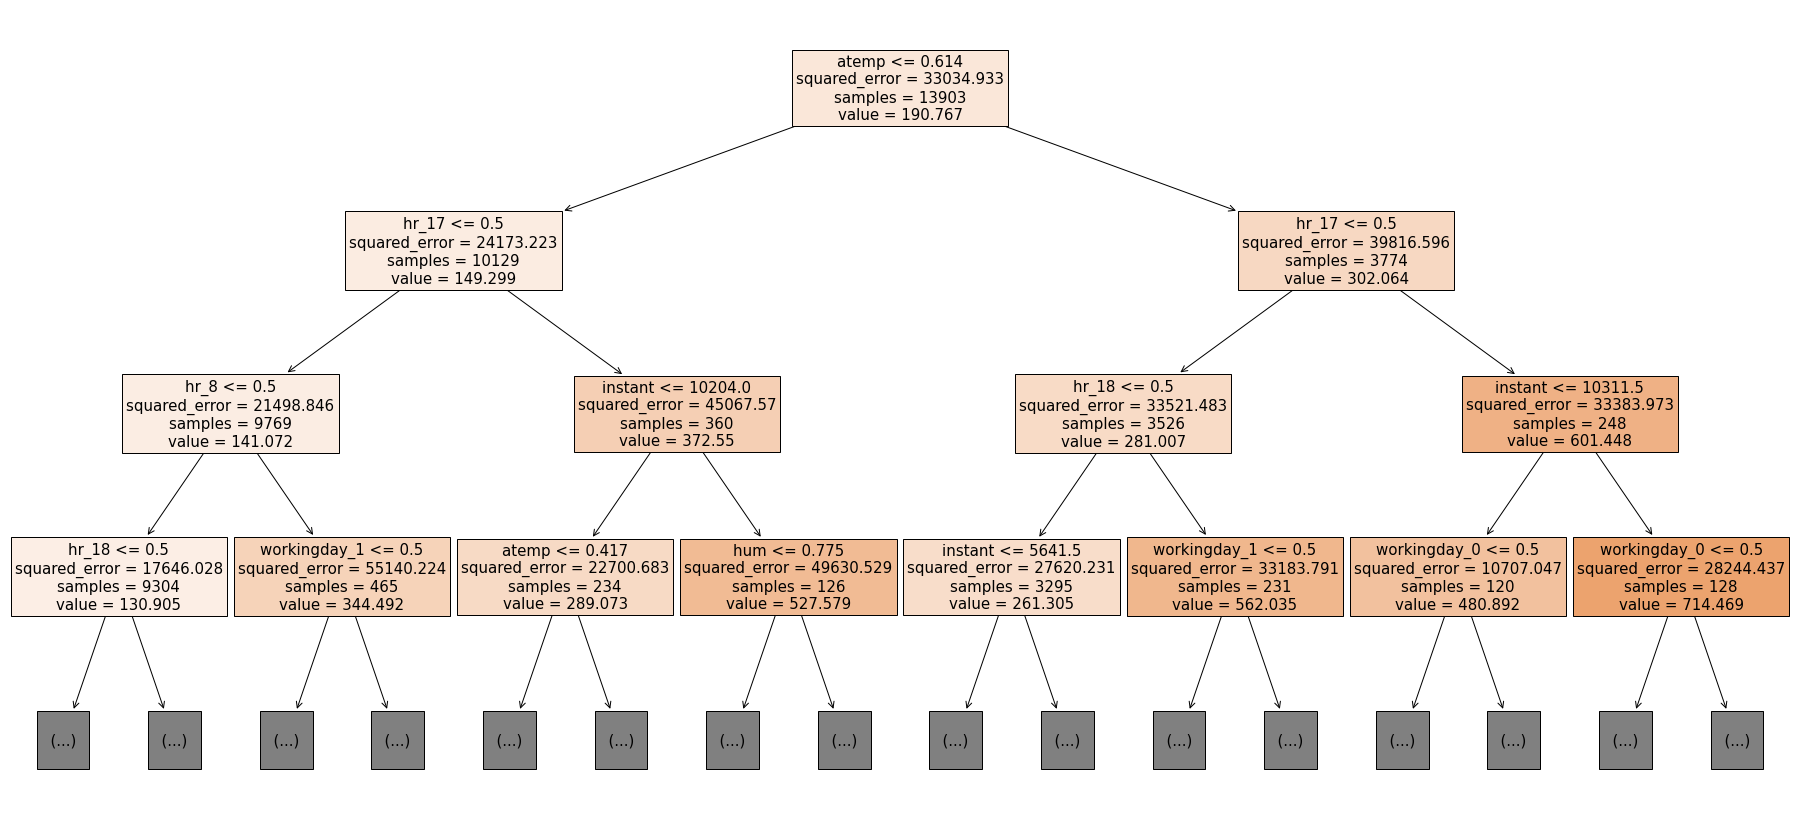

<AxesSubplot:>

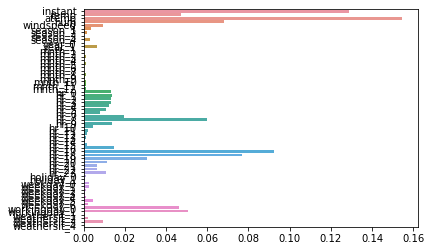

In [46]:
from sklearn.tree import plot_tree
import seaborn as sns

# Plot the decision tree
fig = plt.figure(figsize=(32,15))
plot_tree(dtr, fontsize=15, max_depth=3, feature_names=X_train.columns, class_names=['Not survived', 'Survived'], filled=True)
plt.show()

sns.barplot(x=dtr.feature_importances_, y=X_train.columns)

## Method 4. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor


## Method 7. Support Vector Machine

## Method 8. Neural Networks